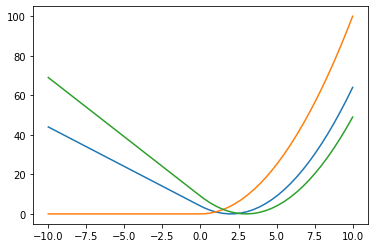

In [12]:
import jax
import numpy as np
import matplotlib.pyplot as plt

import jax
def teststat(x,mu):
    bestfit = jax.numpy.where(x > 0, x, 0)
    return -2*(jax.scipy.stats.norm.logpdf(x,mu) - jax.scipy.stats.norm.logpdf(x,bestfit))

def get_test_stat(mu):
    return lambda x: jax.vmap(teststat, in_axes=(0,None))(x,mu)

gaussian_lr = jax.vmap(teststat, in_axes=(0,None))


xi = np.linspace(-10,10)
li = get_test_stat(2.0)(xi)
plt.plot(xi,li)
li = get_test_stat(0.0)(xi)
plt.plot(xi,li)
li = get_test_stat(3.0)(xi)
plt.plot(xi,li)



    fjac: array([[1.]])
     fun: array([1.23233333e-09])
 message: 'The solution converged.'
    nfev: 25
     qtf: array([1.23233333e-09])
       r: array([-0.02453933])
  status: 1
 success: True
       x: array([3.8414587])

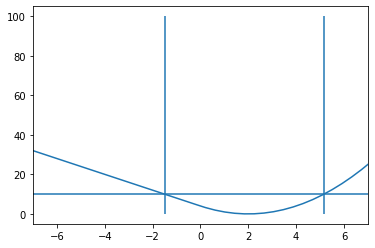

In [2]:
import scipy.optimize

def getcutf(mu):
    def cut(cutval):
        a = scipy.optimize.root(lambda x: get_test_stat(mu)(x) - cutval, mu + 0.1).x
        b = scipy.optimize.root(lambda x: get_test_stat(mu)(x) - cutval, mu - 0.1).x
        li = get_test_stat(mu)(xi)

        right_tail = 1-scipy.stats.norm(mu).cdf(a)
        left_tail = scipy.stats.norm(mu).cdf(b)
        pval = left_tail+right_tail
        return np.array([a,b,pval])
    return cut

a,b,p = getcutf(2.0)(10)
li = get_test_stat(2.0)(xi)
plt.plot(xi,li)
plt.hlines(10,-10,10)
plt.vlines([a,b],0,100)
plt.xlim(-7,7)


scipy.optimize.root(lambda x: getcutf(2.0)(x)[-1]-0.05,10)

In [17]:
def feldman_cousins(mu,level = 0.1):
    #get test stat val for 0.05
    r = scipy.optimize.root(lambda x: getcutf(mu)(x)[-1]-level,20)
    cut = r.x
    #get x interval and p-value for test stat val
    a,b,p = getcutf(mu)(cut)
    return np.array([a,b,p])
    

def feldman_cousins_data(data,mu,level = 0.1):
    #get test stat val for 0.05
    r = scipy.optimize.root(lambda x: getcutf(mu)(x)[-1]-level,20)
    cut = r.x

    #get data test stat val
    d = np.array(get_test_stat(mu)(np.array([data])))

    #get data pval
    _,_,dp = getcutf(mu)(d)
    return np.array([a,b,p,d,dp,cut])[:,0]


In [15]:
hypos = np.linspace(0.01,6,101)
fcr_band = np.array([feldman_cousins(mu) for mu in hypos])

In [16]:
data = 3
fcr_data = np.array([feldman_cousins_data(data,mu) for mu in hypos])

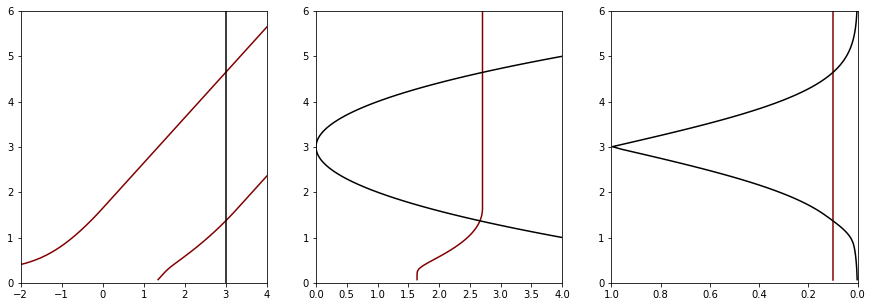

In [8]:
f,axarr  = plt.subplots(1,3)
ax =  axarr[0]
ax.plot(fcr[1:,0],hypos[1:], c = 'maroon')
ax.plot(fcr[1:,1],hypos[1:], c = 'maroon')

ax.vlines(data,0,6, colors = 'k')
ax.set_ylim(0,6)
ax.set_xlim(-2,4)
f.set_size_inches(15,5)

ax = axarr[1]
ax.plot(fcr[1:,-1],hypos[1:], c = 'maroon')
ax.plot(fcr[1:,-3],hypos[1:], c = 'k')
ax.set_xlim(0,4)
ax.set_ylim(0,6)

ax = axarr[2]
ax.plot(fcr[1:,2],hypos[1:], c = 'maroon')
ax.plot(fcr[1:,-2],hypos[1:], c = 'k')
ax.set_xlim(1,0)
ax.set_ylim(0,6)

f.savefig('feldman_cousins.png')